In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay,
    precision_score, recall_score, f1_score
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid")


In [5]:
df = pd.read_csv("application_merged_final.csv")
df.drop(columns=["SK_ID_CURR"], inplace=True)
df = df.dropna(subset=["TARGET"])
missing = df.isnull().sum() / len(df)
df.drop(columns=missing[missing > 0.4].index, inplace=True)
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = df[col].fillna("Unknown")
df = df[df["CODE_GENDER"] != "XNA"]


In [6]:
le = LabelEncoder()
binary_cats = [col for col in cat_cols if df[col].nunique() == 2]
for col in binary_cats:
    df[col] = le.fit_transform(df[col])
multi_cats = [col for col in cat_cols if col not in binary_cats]
df = pd.get_dummies(df, columns=multi_cats, drop_first=True)
df = df.fillna(df.median())
new_cols = pd.DataFrame({
    "CREDIT_INCOME_RATIO": df["AMT_CREDIT"] / df["AMT_INCOME_TOTAL"].replace(0, np.nan),
    "ANNUITY_INCOME_RATIO": df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"].replace(0, np.nan),
    "PAYMENT_RATE": df["AMT_ANNUITY"] / df["AMT_CREDIT"].replace(0, np.nan),
    "AGE_YEARS": abs(df["DAYS_BIRTH"] / 365),
    "INCOME_PER_PERSON": df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"].replace(0, np.nan)
})
df = pd.concat([df, new_cols], axis=1)
df = df.replace([np.inf, -np.inf], np.nan).fillna(df.median())


In [7]:
X = df.drop(columns=["TARGET"])
y = df["TARGET"]
X = X.loc[:, X.nunique() > 1]
X = X.loc[:, ~X.columns.duplicated()]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_raw, X_test, y_train_raw, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)


In [8]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"\n=== {model_name} ===")
    print(f"AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"ROC Curve - {model_name}")
    plt.show()
    if hasattr(model, "feature_importances_"):
        pd.Series(model.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh')
        plt.title(f"Top Features - {model_name}")
        plt.gca().invert_yaxis()
        plt.show()
    if isinstance(model, LogisticRegression):
        coefs = pd.Series(model.coef_[0], index=X.columns)
        coefs.nlargest(10).plot(kind='barh', color='green', title='Top Positive Coefficients')
        plt.gca().invert_yaxis()
        plt.show()
        coefs.nsmallest(10).plot(kind='barh', color='red', title='Top Negative Coefficients')
        plt.gca().invert_yaxis()
        plt.show()
    return auc, model



=== LogisticRegression_SMOTE ===
AUC: 0.7473
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56537
           1       0.16      0.66      0.26      4965

    accuracy                           0.70     61502
   macro avg       0.56      0.68      0.54     61502
weighted avg       0.90      0.70      0.77     61502



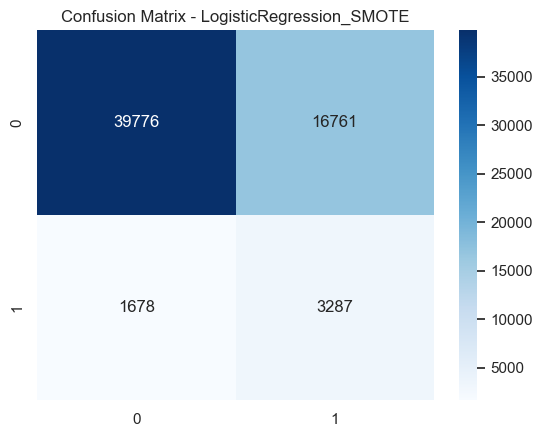

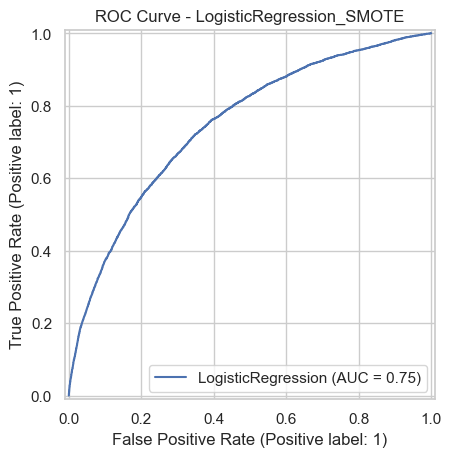

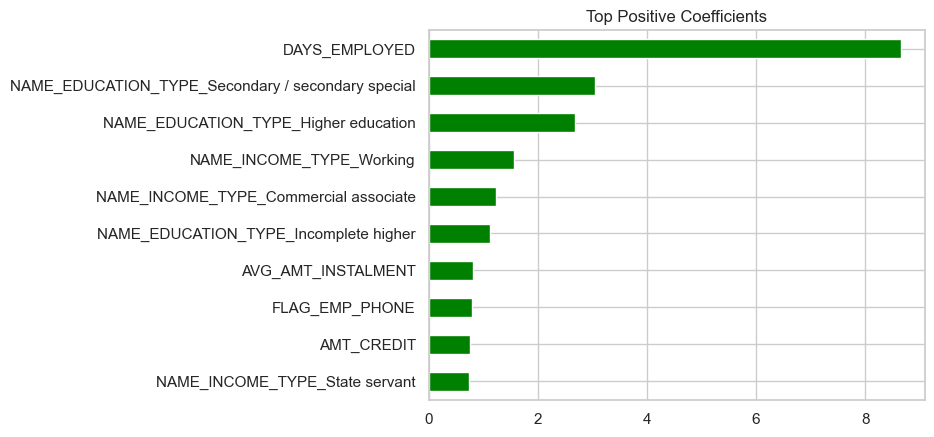

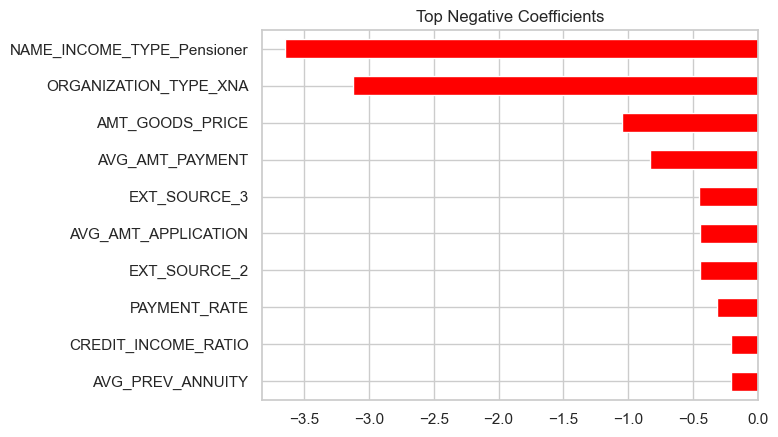


=== RandomForest_SMOTE ===
AUC: 0.7191
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.31      0.02      0.04      4965

    accuracy                           0.92     61502
   macro avg       0.62      0.51      0.50     61502
weighted avg       0.87      0.92      0.88     61502



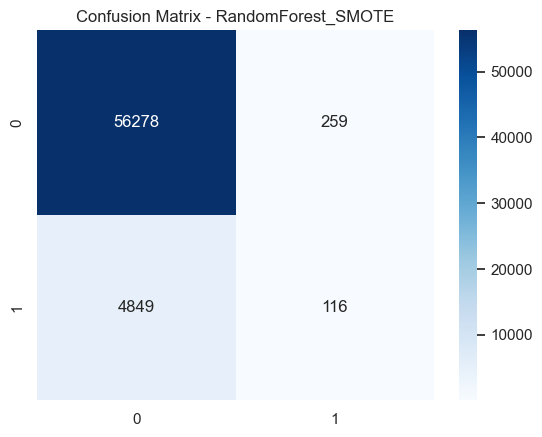

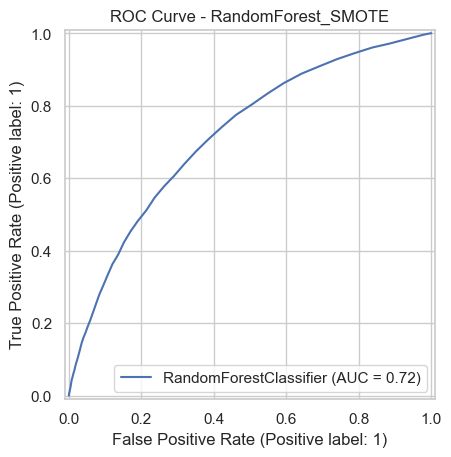

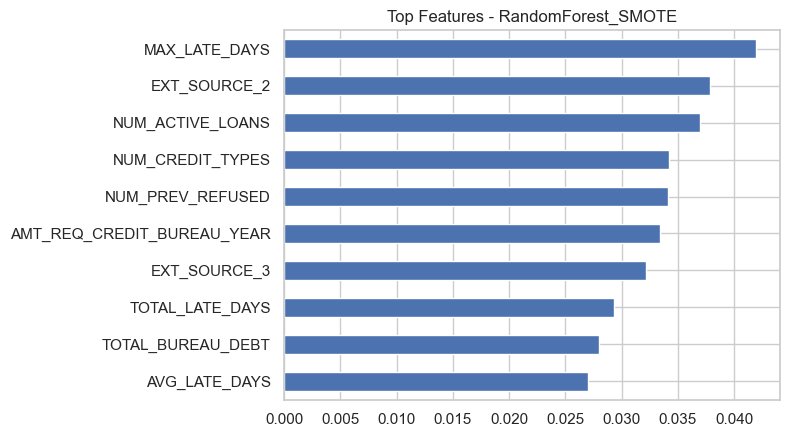


=== XGBoost_SMOTE ===
AUC: 0.7590
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.51      0.05      0.09      4965

    accuracy                           0.92     61502
   macro avg       0.72      0.52      0.53     61502
weighted avg       0.89      0.92      0.89     61502



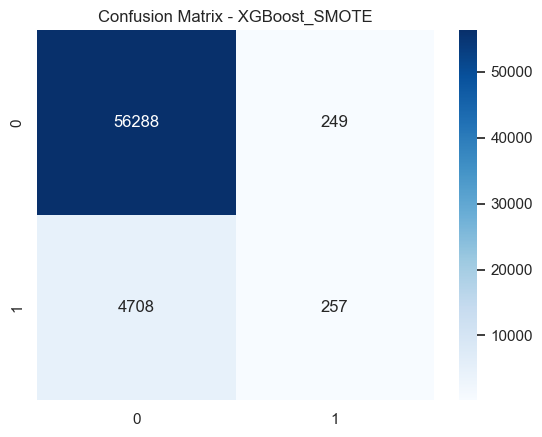

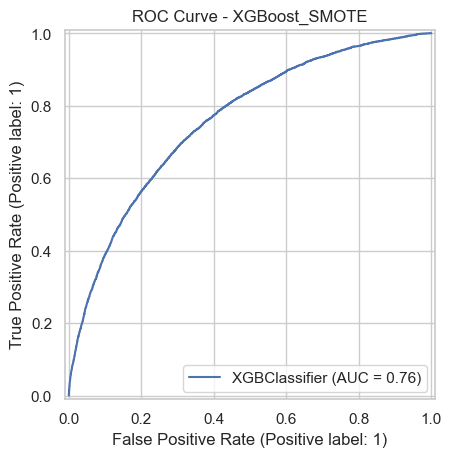

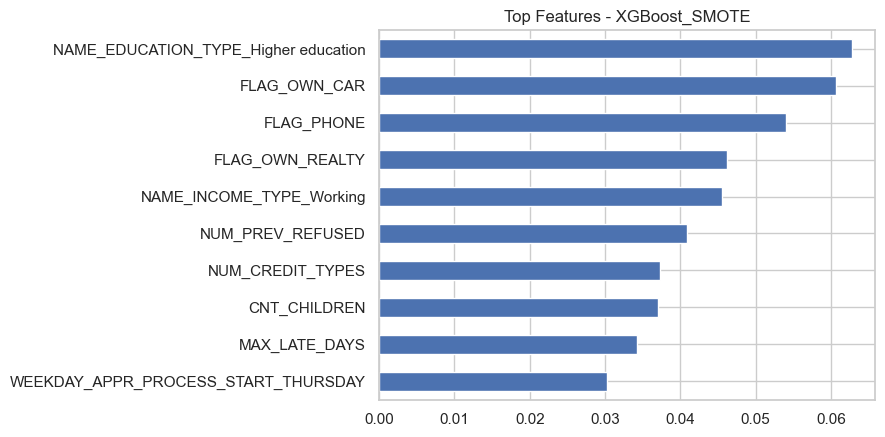


=== LogisticRegression ===
AUC: 0.7543
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.51      0.02      0.03      4965

    accuracy                           0.92     61502
   macro avg       0.71      0.51      0.49     61502
weighted avg       0.89      0.92      0.88     61502



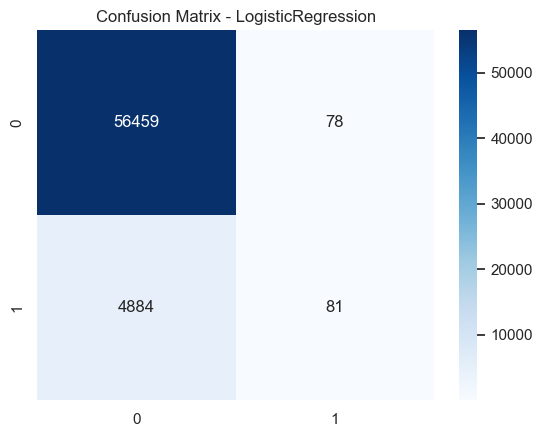

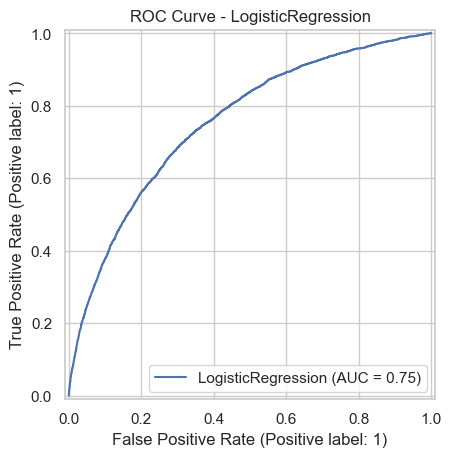

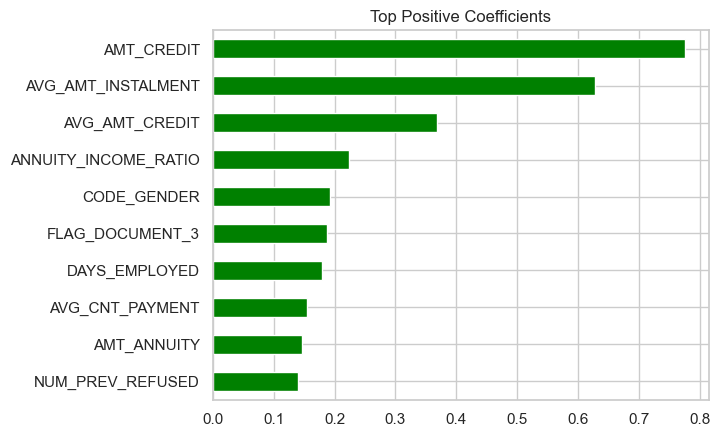

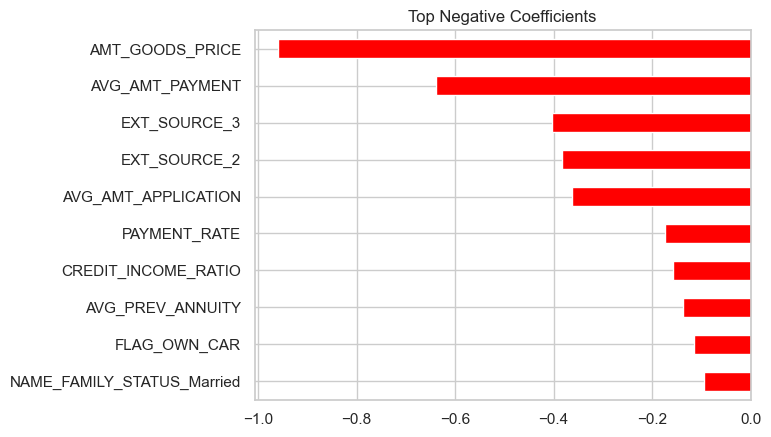


=== RandomForest ===
AUC: 0.7257
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.75      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.83      0.50      0.48     61502
weighted avg       0.91      0.92      0.88     61502



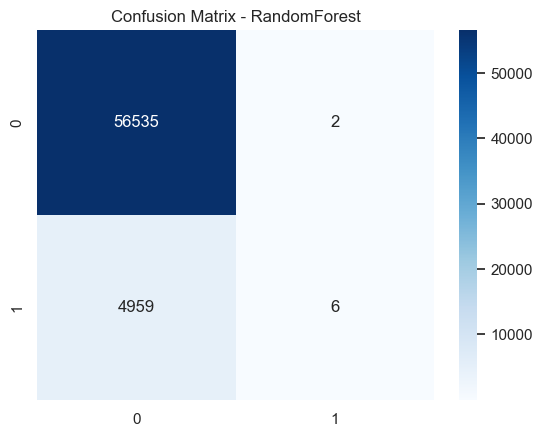

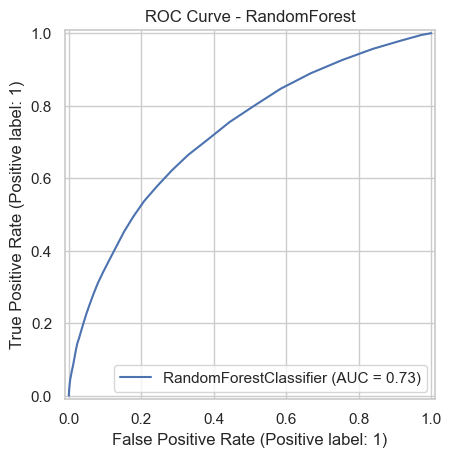

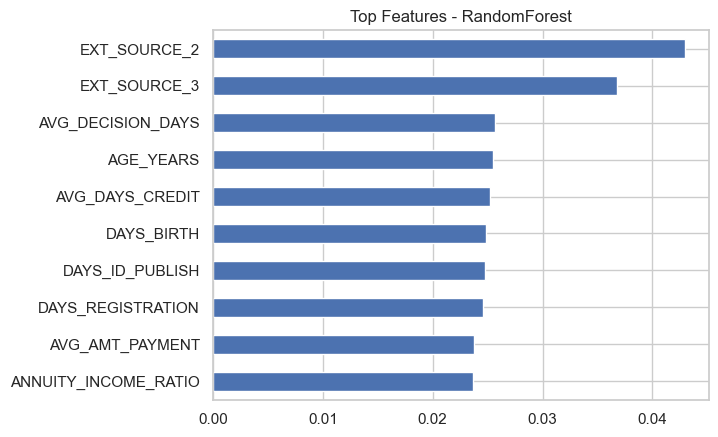


=== XGBoost ===
AUC: 0.7638
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.49      0.05      0.09      4965

    accuracy                           0.92     61502
   macro avg       0.71      0.52      0.53     61502
weighted avg       0.89      0.92      0.89     61502



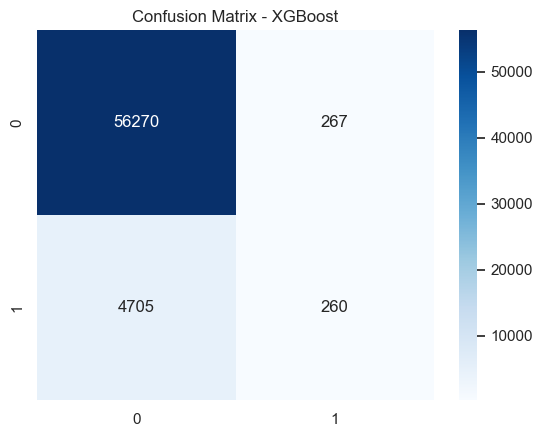

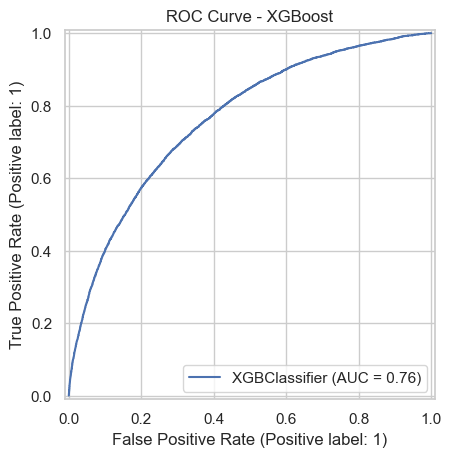

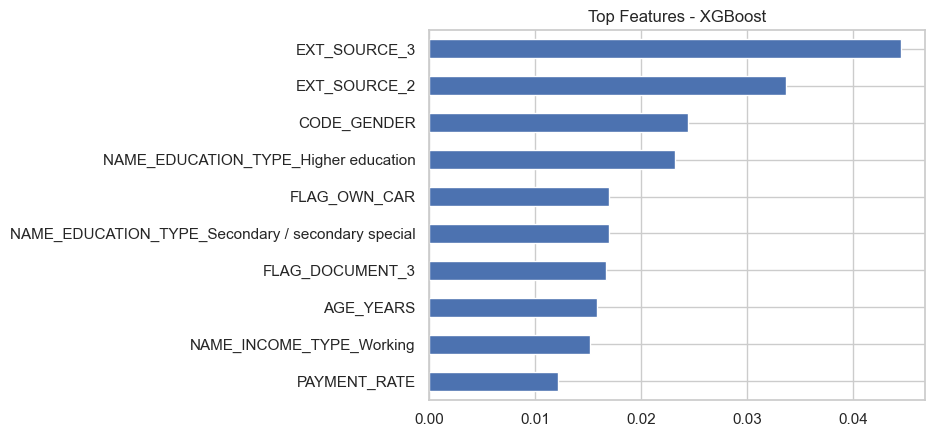

In [9]:
# === Train and evaluate models (SMOTE and No-SMOTE) ===

# Model dengan data SMOTE
models_with_smote = {
    'LogisticRegression_SMOTE': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest_SMOTE': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost_SMOTE': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Model dengan data asli (tanpa SMOTE)
models_no_smote = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Simpan hasil evaluasi
results = {}

# Evaluasi model-model dengan SMOTE
for model_name, model in models_with_smote.items():
    auc, trained_model = evaluate_model(model, X_train, y_train, X_test, y_test, model_name)
    results[model_name] = auc

# Evaluasi model-model tanpa SMOTE
for model_name, model in models_no_smote.items():
    auc, trained_model = evaluate_model(model, X_train_raw, y_train_raw, X_test, y_test, model_name)
    results[model_name] = auc



In [10]:
def extended_metrics(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return {
        "Model": name,
        "AUC": roc_auc_score(y_test, y_proba),
        "Recall_1": recall_score(y_test, y_pred),
        "Precision_1": precision_score(y_test, y_pred),
        "F1_1": f1_score(y_test, y_pred)
    }

all_models = {**models_with_smote, **models_no_smote}  # gabungkan semua
metrics_results = [extended_metrics(model, X_train, y_train, X_test, y_test, name)
                   if 'SMOTE' in name else
                   extended_metrics(model, X_train_raw, y_train_raw, X_test, y_test, name)
                   for name, model in all_models.items()]
pd.DataFrame(metrics_results)


,Model,AUC,Recall_1,Precision_1,F1_1
0,LogisticRegression_SMOTE,0.747256,0.662034,0.163957,0.262823
1,RandomForest_SMOTE,0.719101,0.023364,0.309333,0.043446
2,XGBoost_SMOTE,0.759015,0.051762,0.507905,0.093950
3,LogisticRegression,0.754278,0.016314,0.509434,0.031616
4,RandomForest,0.725686,0.001208,0.750000,0.002413
5,XGBoost,0.763795,0.052367,0.493359,0.094683
